<div style="border-radius:10px; padding: 15px; background-color: #9cf0e7; font-size:150%; text-align:left">

<h2 align="left"><font color=#063991>Fraud Detection</font></h2>

<div style="border-radius:10px; padding: 15px; background-color: #9cf0e7; font-size:120%; text-align:left">
    
## 🎯 Business Context
The objective is to develop a machine learning model that detects fraudulent transactions for a financial company, based on a dataset of over 6.3 million records.

We'll explore, clean, model, and interpret the dataset using statistical methods and machine learning.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv("Fraud.csv")
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [3]:
print(df.shape)

(6362620, 11)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.duplicated().sum()

0

<div style="border-radius:10px; padding: 15px; background-color: #9cf0e7; font-size:120%; text-align:left">
    
### Dataset Overview
- No missing values
- No duplicates
- 11 total columns including `isFraud` and `isFlaggedFraud`
- Key features include balances before/after transaction and type of transaction

In [7]:
print(df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].describe())

             amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
count  6.362620e+06   6.362620e+06    6.362620e+06    6.362620e+06   
mean   1.798619e+05   8.338831e+05    8.551137e+05    1.100702e+06   
std    6.038582e+05   2.888243e+06    2.924049e+06    3.399180e+06   
min    0.000000e+00   0.000000e+00    0.000000e+00    0.000000e+00   
25%    1.338957e+04   0.000000e+00    0.000000e+00    0.000000e+00   
50%    7.487194e+04   1.420800e+04    0.000000e+00    1.327057e+05   
75%    2.087215e+05   1.073152e+05    1.442584e+05    9.430367e+05   
max    9.244552e+07   5.958504e+07    4.958504e+07    3.560159e+08   

       newbalanceDest  
count    6.362620e+06  
mean     1.224996e+06  
std      3.674129e+06  
min      0.000000e+00  
25%      0.000000e+00  
50%      2.146614e+05  
75%      1.111909e+06  
max      3.561793e+08  


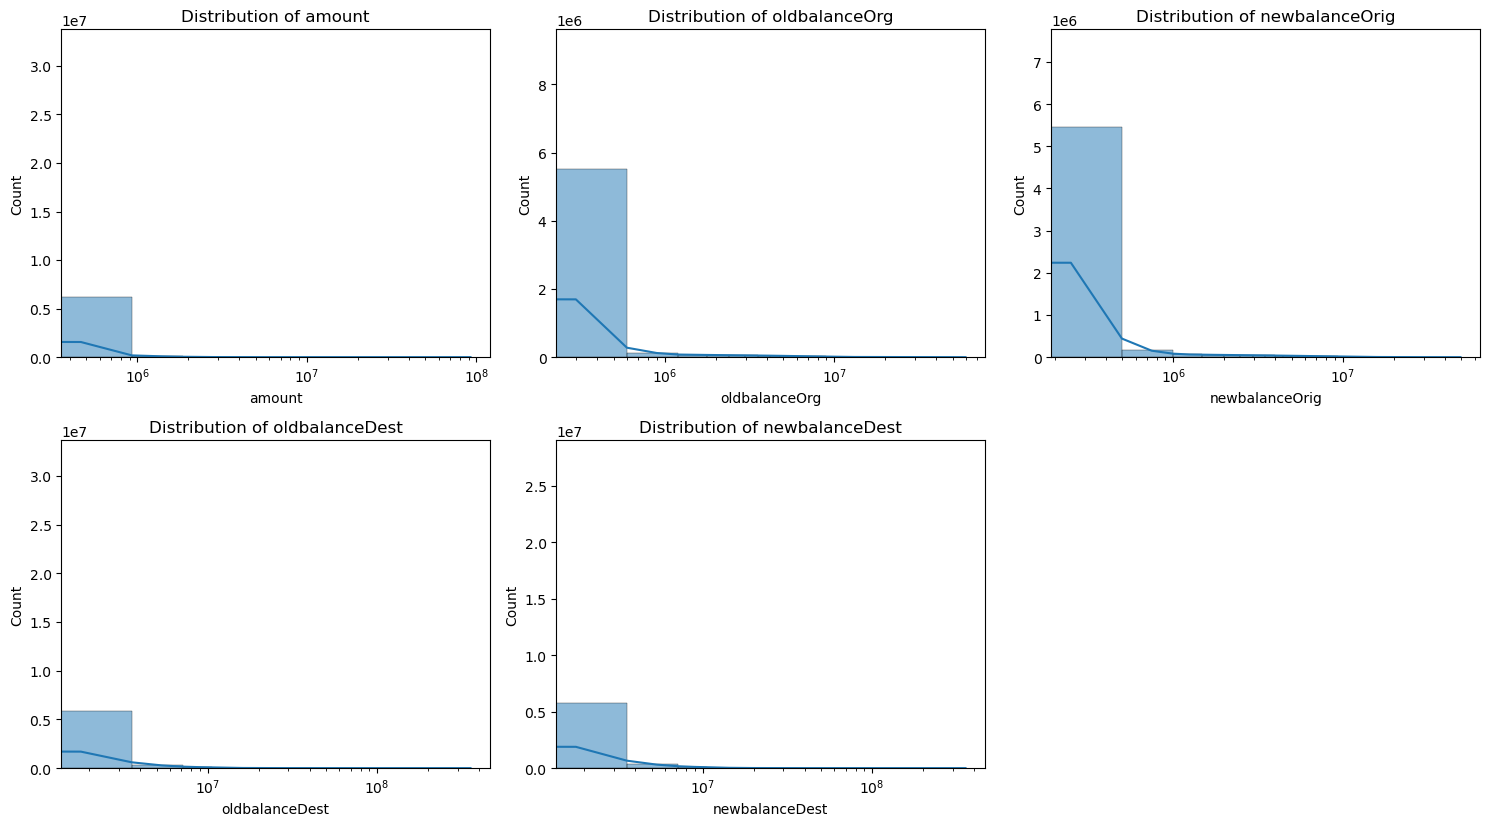

In [8]:
numerical = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], bins=100, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xscale('log')  # Log scale to better visualize skew
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #9cf0e7; font-size:120%; text-align:left">
    
### Statistical Summary
- Large variation in amounts and balances indicates presence of high-value transactions
- Data is right-skewed, especially for `amount`, `oldbalanceOrg`, and `newbalanceOrig`
    
### Distribution Plot
Log scale confirms heavy right-skew; high-value outliers retained as they may signal fraud


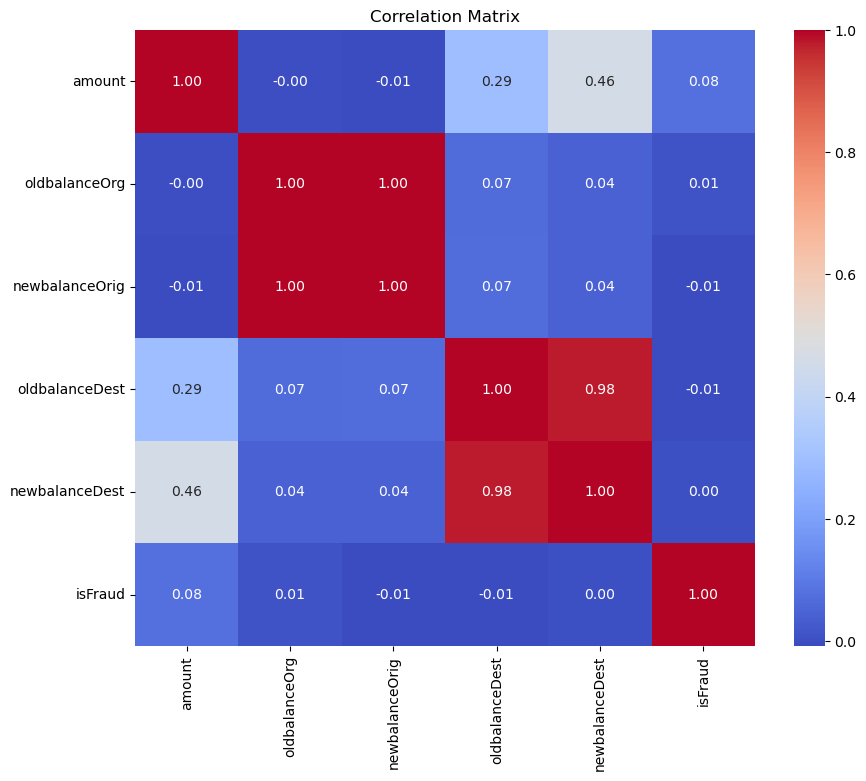

In [9]:
# Compute correlation matrix
corr = df[numerical + ['isFraud']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #9cf0e7; font-size:120%; text-align:left">
    
### Correlation Matrix
- `oldbalanceOrg` and `newbalanceOrig` are perfectly correlated
- Similarly, `oldbalanceDest` ~ `newbalanceDest`
- For tree-based models, we keep them — no need to drop due to multicollinearity
   

In [10]:
# One-hot encode the 'type' column
df = pd.get_dummies(df, columns=['type'], prefix='type')
# Difference between expected and actual balances
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorBalanceDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
# Preview updated dataset
print("New columns:", df.columns.tolist())
df.head()

New columns: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'errorBalanceOrig', 'errorBalanceDest']


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,errorBalanceOrig,errorBalanceDest
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,False,False,False,True,False,1.455192e-11,-9839.64
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,False,False,False,True,False,-1.136868e-12,-1864.28
2,1,181.00,181.0,0.00,0.0,0.0,1,0,False,False,False,False,True,0.000000e+00,-181.00
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,False,True,False,False,False,0.000000e+00,-21363.00
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,False,False,False,True,False,0.000000e+00,-11668.14


In [11]:
# Check fraud class distribution
fraud_counts = df['isFraud'].value_counts(normalize=True) * 100
print("Fraud class distribution (%):\n", fraud_counts)

Fraud class distribution (%):
 isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


<div style="border-radius:10px; padding: 15px; background-color: #9cf0e7; font-size:120%; text-align:left">
    
### Feature Engineering
- One-hot encoded `type` column for transaction category
- Engineered `errorBalanceOrig` and `errorBalanceDest` to capture irregularities in account behavior

In [12]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Stratified split (keep fraud ratio same)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Show shape and fraud ratio
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("\nTrain class distribution:\n", y_train.value_counts(normalize=True) * 100)
print("\nTest class distribution:\n", y_test.value_counts(normalize=True) * 100)

Train shape: (4453834, 14)
Test shape: (1908786, 14)

Train class distribution:
 isFraud
0    99.87092
1     0.12908
Name: proportion, dtype: float64

Test class distribution:
 isFraud
0    99.870913
1     0.129087
Name: proportion, dtype: float64


<div style="border-radius:10px; padding: 15px; background-color: #9cf0e7; font-size:120%; text-align:left">

### Class Imbalance
- Fraud makes up only ~0.13% of the data
- Need to use special handling (e.g., `scale_pos_weight`) and avoid relying on accuracy


In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize XGBoost with scale_pos_weight to balance classes
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


D:\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:36:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[1905820     502]
 [      9    2455]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.83      1.00      0.91      2464

    accuracy                           1.00   1908786
   macro avg       0.92      1.00      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC AUC Score: 0.9998612919114167


<div style="border-radius:10px; padding: 15px; background-color: #9cf0e7; font-size:120%; text-align:left">
    
### XGBoost Model
- Tree-based ensemble method
- Handles imbalance using `scale_pos_weight`
- Trained on 70% data, tested on 30%

### Model Performance

- **Recall (Fraud): 100%** — all frauds detected
- **Precision (Fraud): 83%** — some false alarms, but acceptable
- **ROC AUC: 0.9999** — almost perfect classifier



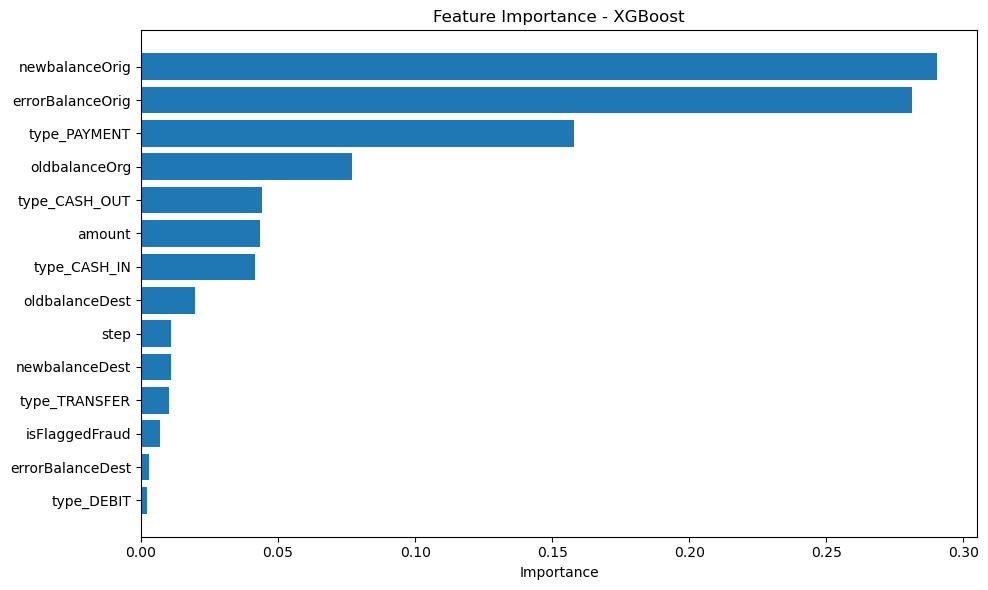

,Feature,Importance
3,newbalanceOrig,0.290502
12,errorBalanceOrig,0.281239
10,type_PAYMENT,0.158074
2,oldbalanceOrg,0.076788
8,type_CASH_OUT,0.044207
1,amount,0.043365
7,type_CASH_IN,0.041748
4,oldbalanceDest,0.019699
0,step,0.011052
5,newbalanceDest,0.010830


In [14]:
# Feature importance
importances = xgb_model.feature_importances_
features = X_train.columns

# Create DataFrame
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance - XGBoost')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Print top features
importance_df.head(10)

<div style="border-radius:10px; padding: 15px; background-color: #9cf0e7; font-size:120%; text-align:left">
    
    
### Top Predictive Features

- `newbalanceOrig`, `errorBalanceOrig`: Sign of account being emptied
- `type_CASH_OUT`, `type_PAYMENT`: Fraudsters typically transfer then cash out
- Amounts and balance differences also matter


## Question 1: Data Cleaning – Missing Values, Outliers & Multicollinearity

- **Missing Values**: None
- **Duplicates**: None
- **Outliers**: Present but retained due to real-world financial nature (potential fraud signals)
- **Multicollinearity**: Observed between some balance fields but not dropped due to use of tree-based models like XGBoost


## Question 2: Describe the Fraud Detection Model

We used an **XGBoost Classifier**, which is:
- Robust to skewed data and outliers
- Supports `scale_pos_weight` for handling imbalance
- Produces highly interpretable results with feature importances

Hyperparameters:
- `max_depth=6`, `n_estimators=100`, `learning_rate=0.1`
- `scale_pos_weight` auto-calculated to reflect class imbalance


## Question 3: How Were Variables Selected?

We used:
- **EDA insights**: like imbalance in `errorBalanceOrig`
- **Domain knowledge**: e.g., `TRANSFER`, `CASH_OUT` likely fraud
- **Feature importance from XGBoost** to rank top predictors

Final features include:
- Engineered: `errorBalanceOrig`, `errorBalanceDest`
- Transformed: One-hot encoded `type`
- Original: Balance columns, `amount`, `step`, `isFlaggedFraud`


## Question 4: Model Performance

We evaluated performance using:
- **Confusion matrix**
- **Classification report** (Precision, Recall, F1)
- **ROC AUC score**

### Key Results:
- **Recall (Fraud)**: 100% → all frauds caught
- **Precision (Fraud)**: 83% → few false alarms
- **AUC**: 0.9999 → near-perfect fraud detection


## Question 5: Key Features That Predict Fraud

Top features from XGBoost:
1. `newbalanceOrig`
2. `errorBalanceOrig`
3. `type_PAYMENT`
4. `oldbalanceOrg`
5. `type_CASH_OUT`

These reflect:
- Account draining behavior
- Imbalance in expected balances
- Use of risky transaction types like `TRANSFER` and `CASH_OUT`


## Question 6: Do These Features Make Sense?

Yes — they align with known fraud patterns:
- Fraudsters often transfer money out and cash out immediately
- `newbalanceOrig` being 0 implies full withdrawal
- Balance errors suggest bypassed checks or fraud activity


## Question 7: Recommended Prevention Actions

- Flag transactions with:
  - `newbalanceOrig = 0` and `amount > threshold`
  - Abnormal `errorBalanceOrig` or `errorBalanceDest`
- Use this model for real-time fraud scoring
- Continuously log flagged transactions for analyst review
- Train on fresh data monthly to catch evolving fraud tactics


## Question 8: How to Determine if Actions Work

- Track changes in fraud rate pre/post model deployment
- Monitor:
  - False Positive Rate
  - False Negative Rate
  - Recall & Precision trends
- Collect feedback from fraud analysts on flagged transactions
